In [2]:
!pip install pretrainedmodels

**ResNet50** - is a convolutional neural network that is 50 layers deep,The pretrained network can classify images into 1000 object categories.
The main innovation of ResNet is the skip connection.as the model backpropagates, the gradient gets smaller and smaller and the gradients may have less influence on the

**ResNext50** - ResNeXt, contains Next in the model which means the next dimension, which called the “cardinality” dimension. hyper-parameter called “cardinality” — the number of independent paths, to provide a new way of adjusting the model capacity. Experiments show that accuracy can be gained more efficiently by increasing the cardinality than by going deeper or wider.

**SeNet**  - introduce a building block for CNNs that improves channel interdependencies at almost no computational cost. Convolutional neural networks are built upon the convolution operation, which extracts informative features . In order to boost the representational power of a network, we use “Squeeze-and-Excitation”(SE) block, that adaptively recalibrates channel-wise feature responses by explicitly modelling interdependencies between channels. We use them by stacking these blocks together.

**VGG16**- is used in many deep learning image classification problems.
its a convolutional neural network model which replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. Due to its depth and number of fully-connected nodes, VGG16 is over 533MB. This makes deploying VGG a tiresome task

In [0]:
from pretrainedmodels import (resnet50, vgg16)
from pretrainedmodels.models import resnext101_32x4d as ResNext50
from pretrainedmodels.models import senet154 as SeNet

In [6]:
!pip install imageio
!pip install kaggle
!pip install torch_optimizer

In [7]:
import os
import glob
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [9]:
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [10]:
pwd

'/content/gdrive/My Drive/kaggle'

In [11]:
!pip install pretrainedmodels

In [12]:
from pretrainedmodels import (resnet50, vgg16)
from pretrainedmodels.models import resnext101_32x4d as ResNext50
from pretrainedmodels.models import senet154 as SeNet
from sklearn.model_selection import train_test_split
import glob
import cv2
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import os
from imgaug import augmenters as iaa
%matplotlib inline
import torch.optim as optim
import torch_optimizer as optim1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

In [0]:
test_paths = glob.glob('/content/gdrive/My Drive/kaggle/224-224-cervical-cancer-screening/kaggle/test/test/*.jpg') 
paths = glob.glob('/content/gdrive/My Drive/kaggle/224-224-cervical-cancer-screening/kaggle/train/train/*/*.jpg') 

In [0]:
train_paths, val_paths = train_test_split(paths, test_size = 0.1, random_state = 2018)

In [16]:
print(len(train_paths),len(val_paths),len(test_paths))

1332 149 512


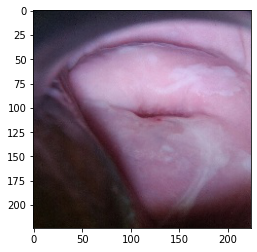

In [17]:
img = plt.imread(train_paths[4])
plt.imshow(img)

In [0]:
sometimes = lambda aug : iaa.Sometimes(0.5, aug)

In [0]:
seq = iaa.Sequential([
    sometimes(iaa.ElasticTransformation(alpha=(0,10),sigma=10)),
    sometimes(iaa.Affine(translate_px=(-30,30),rotate =(-120,120),cval = 0 )),
    sometimes(iaa.Crop(percent=(0,0.1))),
    sometimes(iaa.PiecewiseAffine(scale = (0.01,0.05)))
],random_order = True)

In [0]:
def make_augmantations(p = 1):
     return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((-120,120)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])])

In [0]:
class MyDataSet(Dataset):
    def __init__(self, paths, train = True, transform = None):
        self.paths = paths
        self.train = train
        self.transform = transform
        # self.size = size

    def __getitem__(self, idx):
        p = self.paths[idx]
        label = p.split("/")[-2].split("_")[-1]
        image = cv2.imread(p)
        image = cv2.cvtColor(image,(cv2.COLOR_BGR2RGB))
        target = torch.zeros(3)
        target[int(label)- 1] = 1.0
        # target = int(label) - 1
        if self.train :
            image = seq.augment_image(image)   
        if self.transform != None:  
            image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, target
    
    def __len__(self):
        return len(self.paths)

In [0]:
train_transforms = make_augmantations()
test_trandforms = make_augmantations()

trainset = MyDataSet(train_paths,transform =train_transforms,train=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size = 8 ,shuffle=True)
valset = MyDataSet(val_paths,transform = test_trandforms,train=True)
val_loader = torch.utils.data.DataLoader(valset,batch_size = 8,shuffle=False)
testset = MyDataSet(test_paths,transform = test_trandforms,train=True)

In [0]:
def norm(img):
    img -=img.min()
    img/=img.max()
    return img

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


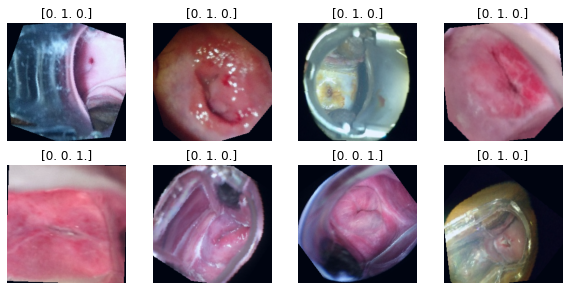

In [24]:
batch = iter(val_loader)
img,label = next(batch)
img = img.cpu().numpy()
label = label.cpu().numpy()
plt.figure(figsize=[10, 10])
for i, (row, t) in enumerate(zip(img, label)):
    plt.subplot(4, 4, i+1)
    im = row.transpose(1, 2, 0)
    plt.imshow(norm(im))
    plt.title(t)
    plt.axis('off')
plt.show()

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
#image size : 224X224X3
    #dim_after_conv = input_size -(filter_zise - 1)
    #dim_after_max_pool = input_size /2 

    # size of input image :  224x224X3
    # after first conv2d : 224 - (5 -1) = 220, #224 - (5 -1) = 220
    # img size : 220x220x6

    # after max_pool :220/2 = 110 , #220/2= 110
    # img size = 110x110x6

    #after 2nd conv2d : 110 - (5-1) = 106 , #110- (5-1) = 106
    #img size : 106x106x16

    # after max_pool :106/2= 53, #106/2= 53
    # img size = 53x53x16

class LeNet(nn.Module): 
    def __init__(self):
        super(LeNet ,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(in_features = 53*53*16 ,out_features = 120)
        self.fc2 = nn.Linear(in_features = 120 ,out_features = 84)                              
        self.fc3 = nn.Linear(in_features = 84 ,out_features = 3)

    def forward(self, x):
        x = self.conv1(x.float())

        x = F.relu(x)
        x = F.max_pool2d(x ,2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x).double()
        # x = F.relu(x)
        # x = F.softmax(x,dim = 1).double()
        return x

In [0]:
lenet = LeNet()
resnet = resnet50()
# resnext = ResNext50()

In [0]:
lenet = lenet.to(device)
resnet = resnet.to(device)
# resnext = resnext.to(device)

In [0]:
def optimizers(params,option): 
    if option == 'sgd':
        optimizer = optim.SGD(params,lr=0.01)
    if option == 'adam':
        optimizer = optim.Adam(params,lr=1e-4)
    if option == 'radam':
        optimizer = optim1.RAdam(params,lr=1e-3,betas=(0.9,0.999),eps=1e-8)
    return optimizer

In [0]:
adam_optim = optimizers(lenet.parameters(),'adam')

In [0]:
# def focal_loss1(input1, target,alpha, gamma):
#     BCE_loss = F.binary_cross_entropy(input1, target)
#     pt = torch.exp(-BCE_loss)
#     return (alpha)* ((1-pt)**gamma)* BCE_loss

class MyFocalLoss(nn.Module):
  def __init__(self, alpha=0.25, gamma=2.0):
      super(MyFocalLoss, self).__init__()
      self.alpha  = alpha
      self.gamma  = gamma
      self.my_ce = nn.CrossEntropyLoss()

  def forward(self, input, target):
      p_t = torch.exp(-self.my_ce(input, target))
      loss = self.my_ce(input, target) * self.alpha * (torch.pow((1 - p_t), self.gamma))
      return loss


In [0]:
def evaluation(actual, pred, one_hot = True):
    acuuracy = 0.0
    total_hits = 0.0 
    lst_actual = list()
    lst_pred = list()
    if one_hot:
        for a in actual :
            lst_actual.append(torch.argmax(a))
        for p in pred : 
            lst_pred.append(torch.argmax(p))

    for a,p in zip(actual.argmax(dim=-1) , pred.argmax(dim=-1)):
        if a == p:
            total_hits += 1.0
    acuuracy = total_hits / len(actual)
    return acuuracy

In [0]:
from tqdm.auto import tqdm

In [0]:
def training_loop(data_loader_train, data_loader_val, test):
    conv_list = list()
    accur_lst = list()
    loss_fn = MyFocalLoss()
    loss_fn.to(device)
    for _ in range(10):
        acc_loss = 0.0 
        acc = 0
        for i, sample in enumerate(tqdm(data_loader_train, desc = "train")):
            x_train, y_train = sample[0].to(device), sample[1].to(device)
            adam_optim.zero_grad()
            output = lenet(x_train)
            loss = loss_fn(output, y_train.long())
            # print('output', output, 'item', loss.item())
            loss.backward()          
            adam_optim.step() 
            acc += evaluation(y_train, output, one_hot = False)          
            acc_loss += loss.item()
            if i %20==19:
                accur_lst.append(acc) 
                conv_list.append(loss.item()) 
                print('Training:[%d, %5d] loss: %.15f, accuracy: %f' %(_ + 1, i + 1, acc_loss/20, acc/20))
                acc_loss = 0.0
                acc = 0

        if not test:
            acc_loss = 0.0
            acc = 0
            with torch.no_grad():
                for idx, sample1 in enumerate(data_loader_val, 0):
                    x_val, y_val = sample1[0].to(device), sample1[1].to(device)
                    output = lenet(x_val)
                    acc += evaluation(y_val, output, one_hot = False)
                    loss = loss_fn(output, y_val.long())
                    acc_loss += loss.item()
                print('Validation:[%d, %5d] loss: %.15f, accuracy: %f' %(_ + 1, idx + 1, acc_loss/len(data_loader_val), acc/len(data_loader_val)))
    return conv_list, accur_lst

conv_list1, accur_lst1 = training_loop(train_loader, val_loader, test=False)

Training:[1,    20] loss: 0.100745784906695, accuracy: 0.575000
Training:[1,    40] loss: 0.108877585181087, accuracy: 0.381250
Training:[1,    60] loss: 0.099119437403863, accuracy: 0.531250
Training:[1,    80] loss: 0.112094184502991, accuracy: 0.443750
Training:[1,   100] loss: 0.094688607078554, accuracy: 0.593750
Training:[1,   120] loss: 0.099448446331066, accuracy: 0.537500
Training:[1,   140] loss: 0.102073275560564, accuracy: 0.537500
Training:[1,   160] loss: 0.097778418181966, accuracy: 0.581250

Validation:[1,    19] loss: 0.113950818221519, accuracy: 0.465789


Training:[2,    20] loss: 0.109917756572181, accuracy: 0.475000
Training:[2,    40] loss: 0.107511816234328, accuracy: 0.487500
Training:[2,    60] loss: 0.102720460209077, accuracy: 0.512500
Training:[2,    80] loss: 0.079883350959778, accuracy: 0.618750
Training:[2,   100] loss: 0.104113556106975, accuracy: 0.506250
Training:[2,   120] loss: 0.097519225698422, accuracy: 0.556250
Training:[2,   140] loss: 0.086234832540780, accuracy: 0.581250
Training:[2,   160] loss: 0.097256301513852, accuracy: 0.531250

Validation:[2,    19] loss: 0.109738752475580, accuracy: 0.525000


Training:[3,    20] loss: 0.091391073338540, accuracy: 0.568750
Training:[3,    40] loss: 0.085887658116006, accuracy: 0.550000
Training:[3,    60] loss: 0.112539530556168, accuracy: 0.475000
Training:[3,    80] loss: 0.094858199159578, accuracy: 0.556250
Training:[3,   100] loss: 0.092465277205635, accuracy: 0.568750
Training:[3,   120] loss: 0.080617970210557, accuracy: 0.600000
Training:[3,   140] loss: 0.097174045962494, accuracy: 0.512500
Training:[3,   160] loss: 0.090546834159385, accuracy: 0.531250

Validation:[3,    19] loss: 0.105278430259479, accuracy: 0.492105


Training:[4,    20] loss: 0.096857273373451, accuracy: 0.531250
Training:[4,    40] loss: 0.094508580272267, accuracy: 0.562500
Training:[4,    60] loss: 0.091031894261778, accuracy: 0.581250
Training:[4,    80] loss: 0.083283591034315, accuracy: 0.587500
Training:[4,   100] loss: 0.082326378303232, accuracy: 0.587500
Training:[4,   120] loss: 0.092912972001816, accuracy: 0.518750
Training:[4,   140] loss: 0.098148751968536, accuracy: 0.468750
Training:[4,   160] loss: 0.085187872715971, accuracy: 0.543750

Validation:[4,    19] loss: 0.103656531498805, accuracy: 0.485526


Training:[5,    20] loss: 0.078062773437286, accuracy: 0.587500
Training:[5,    40] loss: 0.096729905761631, accuracy: 0.518750
Training:[5,    60] loss: 0.075112733627054, accuracy: 0.593750
Training:[5,    80] loss: 0.091809299186290, accuracy: 0.543750
Training:[5,   100] loss: 0.088117018102550, accuracy: 0.562500
Training:[5,   120] loss: 0.089726964001414, accuracy: 0.543750
Training:[5,   140] loss: 0.087845181870072, accuracy: 0.506250
Training:[5,   160] loss: 0.091255355047649, accuracy: 0.537500

Validation:[5,    19] loss: 0.096071558714263, accuracy: 0.534211


Training:[6,    20] loss: 0.091154009275778, accuracy: 0.531250
Training:[6,    40] loss: 0.080687239296759, accuracy: 0.568750
Training:[6,    60] loss: 0.098196848285768, accuracy: 0.537500
Training:[6,    80] loss: 0.079231612455138, accuracy: 0.581250
Training:[6,   100] loss: 0.099469650166085, accuracy: 0.518750
Training:[6,   120] loss: 0.090154912057190, accuracy: 0.568750
Training:[6,   140] loss: 0.085182517374890, accuracy: 0.568750
Training:[6,   160] loss: 0.074187435260713, accuracy: 0.575000

Validation:[6,    19] loss: 0.106433765146679, accuracy: 0.505263


Training:[7,    20] loss: 0.090451291789737, accuracy: 0.543750
Training:[7,    40] loss: 0.082599507250339, accuracy: 0.568750
Training:[7,    60] loss: 0.101188944851481, accuracy: 0.525000
Training:[7,    80] loss: 0.089950219141705, accuracy: 0.550000
Training:[7,   100] loss: 0.084087792359445, accuracy: 0.568750
Training:[7,   120] loss: 0.082430138464198, accuracy: 0.512500
Training:[7,   140] loss: 0.081432046201972, accuracy: 0.587500
Training:[7,   160] loss: 0.079099608815196, accuracy: 0.631250

Validation:[7,    19] loss: 0.103793874467497, accuracy: 0.459211


Training:[8,    20] loss: 0.076466221110116, accuracy: 0.587500
Training:[8,    40] loss: 0.078717650652991, accuracy: 0.600000
Training:[8,    60] loss: 0.087275494266972, accuracy: 0.543750
Training:[8,    80] loss: 0.097463755906334, accuracy: 0.493750
Training:[8,   100] loss: 0.094795471657233, accuracy: 0.506250
Training:[8,   120] loss: 0.073320357705785, accuracy: 0.593750
Training:[8,   140] loss: 0.081455098422255, accuracy: 0.587500
Training:[8,   160] loss: 0.083150643688511, accuracy: 0.575000

Validation:[8,    19] loss: 0.111281421160568, accuracy: 0.498684


Training:[9,    20] loss: 0.087504325742717, accuracy: 0.518750
Training:[9,    40] loss: 0.085558700460964, accuracy: 0.568750
Training:[9,    60] loss: 0.087445495156191, accuracy: 0.550000
Training:[9,    80] loss: 0.080356719615695, accuracy: 0.506250
Training:[9,   100] loss: 0.082507519992546, accuracy: 0.575000
Training:[9,   120] loss: 0.081561268993693, accuracy: 0.537500
Training:[9,   140] loss: 0.082331220216397, accuracy: 0.575000
Training:[9,   160] loss: 0.082228340689607, accuracy: 0.556250

Validation:[9,    19] loss: 0.095652861529258, accuracy: 0.514474


Training:[10,    20] loss: 0.074415176766600, accuracy: 0.543750
Training:[10,    40] loss: 0.079028074284293, accuracy: 0.587500
Training:[10,    60] loss: 0.077999343237926, accuracy: 0.593750
Training:[10,    80] loss: 0.076271026552619, accuracy: 0.606250
Training:[10,   100] loss: 0.084585819423553, accuracy: 0.568750
Training:[10,   120] loss: 0.073654058552752, accuracy: 0.618750
Training:[10,   140] loss: 0.095172060081989, accuracy: 0.531250
Training:[10,   160] loss: 0.090534691938790, accuracy: 0.468750

Validation:[10,    19] loss: 0.097780386674079, accuracy: 0.477632


## **Resnet50**

In [0]:
mymodel1 = torch.nn.Sequential(torch.nn.Linear(2048,64),
                             torch.nn.ReLU(),
                             torch.nn.Dropout(),
                             torch.nn.Linear(64,3)).to(device)

In [0]:
scheduler = optim.lr_scheduler.StepLR(adam_optim, step_size=7, gamma=0.1)

In [0]:
def training_loop1(data_loader_train, data_loader_val, mymodel ,model, test):
    conv_list = list()
    accur_lst = list()
    loss_func = nn.BCEWithLogitsLoss()
    loss_func.to(device)
    mymodel.train()
    model.train().to(device)
    for e in range(10):
        acc = 0
        acc_loss = 0.0
        for i, sample in tqdm(enumerate(data_loader_train, 0),desc = "train"):
            x_train, y_train = sample[0].to(device), sample[1].to(device)
            output = model.features(x_train)
            output = torch.functional.F.avg_pool2d(output,7)
            output = output.view(output.shape[0],-1)
            y = mymodel(output)
            loss = loss_func(y.double(), y_train.double())
            loss.backward()          
            adam_optim.step()             
            adam_optim.zero_grad()
            acc += evaluation(y_train, y, one_hot = True)
            acc_loss += loss.item()
            if i %20==19:
                accur_lst.append(acc) 
                conv_list.append(loss.item()) 
                print('Training:[%d, %5d] loss: %.15f, accuracy: %f' %(e + 1, i + 1, acc_loss/20, acc/20))
                acc_loss = 0.0
                acc = 0

        if not test:
            acc_loss = 0.0
            acc = 0
            mymodel.eval()
            model.eval()
            with torch.no_grad():
                for idx, sample1 in enumerate(data_loader_val, 0):
                    x_val, y_val = sample1[0].to(device), sample1[1].to(device)
                    output_val = model.features(x_val)
                    output_val = torch.functional.F.avg_pool2d(output_val,7)
                    output_val = output_val.view(output_val.shape[0],-1)
                    y_v = mymodel(output_val)
                    loss = loss_func(y_v.double(), y_val.double())
                    acc += evaluation(y_val, y_v, one_hot = True)
                    acc_loss += loss.item()
                print('Validation:[%d, %5d] loss: %.15f, accuracy: %f' %(e + 1, idx + 1, acc_loss/len(data_loader_val), acc/len(data_loader_val)))
        scheduler.step()
    return conv_list, accur_lst



In [0]:
conv_list2, accur_lst2 = training_loop1(train_loader, val_loader ,mymodel1, resnet, test=False)

Training:[1,    20] loss: 0.683696971238607, accuracy: 0.343750
Training:[1,    40] loss: 0.674374169288224, accuracy: 0.418750
Training:[1,    60] loss: 0.675987486492361, accuracy: 0.343750
Training:[1,    80] loss: 0.674573409747556, accuracy: 0.418750
Training:[1,   100] loss: 0.674051869851059, accuracy: 0.400000
Training:[1,   120] loss: 0.671941780752661, accuracy: 0.412500
Training:[1,   140] loss: 0.679067170859642, accuracy: 0.337500
Training:[1,   160] loss: 0.673700970526374, accuracy: 0.493750

Validation:[1,    19] loss: 0.675121847485432, accuracy: 0.400000


Training:[2,    20] loss: 0.672958355050681, accuracy: 0.443750
Training:[2,    40] loss: 0.670676005374756, accuracy: 0.531250
Training:[2,    60] loss: 0.671691342509944, accuracy: 0.418750
Training:[2,    80] loss: 0.676127893222583, accuracy: 0.418750
Training:[2,   100] loss: 0.671802888444679, accuracy: 0.468750
Training:[2,   120] loss: 0.675414332344361, accuracy: 0.400000
Training:[2,   140] loss: 0.675298265119722, accuracy: 0.481250
Training:[2,   160] loss: 0.674377655030477, accuracy: 0.400000

Validation:[2,    19] loss: 0.674748683448652, accuracy: 0.397368


Training:[3,    20] loss: 0.674196682714924, accuracy: 0.443750
Training:[3,    40] loss: 0.670998016471109, accuracy: 0.443750
Training:[3,    60] loss: 0.674627346149105, accuracy: 0.425000
Training:[3,    80] loss: 0.674231614443748, accuracy: 0.468750
Training:[3,   100] loss: 0.672630775530909, accuracy: 0.487500
Training:[3,   120] loss: 0.674817600857485, accuracy: 0.481250
Training:[3,   140] loss: 0.673719338977435, accuracy: 0.506250
Training:[3,   160] loss: 0.673578009050910, accuracy: 0.412500

Validation:[3,    19] loss: 0.676876714419955, accuracy: 0.402632


Training:[4,    20] loss: 0.675479656332520, accuracy: 0.393750
Training:[4,    40] loss: 0.675142377596857, accuracy: 0.437500
Training:[4,    60] loss: 0.675910854641427, accuracy: 0.406250
Training:[4,    80] loss: 0.671520699818980, accuracy: 0.450000
Training:[4,   100] loss: 0.675848303647408, accuracy: 0.431250
Training:[4,   120] loss: 0.669306573451495, accuracy: 0.562500
Training:[4,   140] loss: 0.675552555390200, accuracy: 0.456250
Training:[4,   160] loss: 0.673560494853283, accuracy: 0.481250

Validation:[4,    19] loss: 0.675253270075470, accuracy: 0.413158


Training:[5,    20] loss: 0.675823127483797, accuracy: 0.437500
Training:[5,    40] loss: 0.673247101786884, accuracy: 0.425000
Training:[5,    60] loss: 0.670968290993705, accuracy: 0.493750
Training:[5,    80] loss: 0.675375583778904, accuracy: 0.462500
Training:[5,   100] loss: 0.670878903565549, accuracy: 0.437500
Training:[5,   120] loss: 0.671879451863688, accuracy: 0.481250
Training:[5,   140] loss: 0.670518721461192, accuracy: 0.475000
Training:[5,   160] loss: 0.674718020713379, accuracy: 0.412500

Validation:[5,    19] loss: 0.675151673984479, accuracy: 0.363158


Training:[6,    20] loss: 0.671973614742822, accuracy: 0.512500
Training:[6,    40] loss: 0.672675083120667, accuracy: 0.462500
Training:[6,    60] loss: 0.673720244327655, accuracy: 0.412500
Training:[6,    80] loss: 0.674147560927395, accuracy: 0.406250
Training:[6,   100] loss: 0.674594409513883, accuracy: 0.425000
Training:[6,   120] loss: 0.675834696100908, accuracy: 0.462500
Training:[6,   140] loss: 0.675249058442353, accuracy: 0.462500
Training:[6,   160] loss: 0.673436551255028, accuracy: 0.418750

Validation:[6,    19] loss: 0.675487971391456, accuracy: 0.426316


Training:[7,    20] loss: 0.675862085958433, accuracy: 0.381250
Training:[7,    40] loss: 0.676636265742574, accuracy: 0.381250
Training:[7,    60] loss: 0.674114942102439, accuracy: 0.475000
Training:[7,    80] loss: 0.669369937108463, accuracy: 0.512500
Training:[7,   100] loss: 0.671977499896445, accuracy: 0.481250
Training:[7,   120] loss: 0.673867780786954, accuracy: 0.456250
Training:[7,   140] loss: 0.674600716243275, accuracy: 0.425000
Training:[7,   160] loss: 0.676097110560348, accuracy: 0.418750

Validation:[7,    19] loss: 0.673928994619679, accuracy: 0.419737


Training:[8,    20] loss: 0.674360103746929, accuracy: 0.431250
Training:[8,    40] loss: 0.671129955689578, accuracy: 0.537500
Training:[8,    60] loss: 0.671431315576276, accuracy: 0.456250
Training:[8,    80] loss: 0.673321541507094, accuracy: 0.475000
Training:[8,   100] loss: 0.674034642901676, accuracy: 0.387500
Training:[8,   120] loss: 0.677439126209789, accuracy: 0.362500
Training:[8,   140] loss: 0.673779156720995, accuracy: 0.437500
Training:[8,   160] loss: 0.676778697663665, accuracy: 0.450000

Validation:[8,    19] loss: 0.675087904121518, accuracy: 0.443421


Training:[9,    20] loss: 0.672843630403432, accuracy: 0.462500
Training:[9,    40] loss: 0.668527103805250, accuracy: 0.525000
Training:[9,    60] loss: 0.672200826126908, accuracy: 0.462500
Training:[9,    80] loss: 0.676196072031309, accuracy: 0.425000
Training:[9,   100] loss: 0.672443671898789, accuracy: 0.475000
Training:[9,   120] loss: 0.674056690772683, accuracy: 0.475000
Training:[9,   140] loss: 0.672669058010185, accuracy: 0.450000
Training:[9,   160] loss: 0.674865089856596, accuracy: 0.387500

Validation:[9,    19] loss: 0.674200782031292, accuracy: 0.472368


Training:[10,    20] loss: 0.672669226155328, accuracy: 0.462500
Training:[10,    40] loss: 0.671442541424345, accuracy: 0.506250
Training:[10,    60] loss: 0.674414135187417, accuracy: 0.393750
Training:[10,    80] loss: 0.671816331407144, accuracy: 0.437500
Training:[10,   100] loss: 0.672613580458917, accuracy: 0.437500
Training:[10,   120] loss: 0.673953795393070, accuracy: 0.431250
Training:[10,   140] loss: 0.673933408039736, accuracy: 0.475000
Training:[10,   160] loss: 0.673205307597182, accuracy: 0.456250

Validation:[10,    19] loss: 0.674474871716387, accuracy: 0.417105


Resnext -there was problem to run resnext, i ran this before and it was good, but few hours before the submission i tried to run this again and had errors, heard about this also from another students.

In [0]:
conv_list_resnext, accur_lst_resnext = training_loop1(train_loader, val_loader ,mymodel1, resnext, test=False)

Training:[1,    20] loss: 0.669270020936042, accuracy: 0.431250
Training:[1,    40] loss: 0.670685222311206, accuracy: 0.425000
Training:[1,    60] loss: 0.674720219241822, accuracy: 0.393750
Training:[1,    80] loss: 0.677977673767315, accuracy: 0.343750
Training:[1,   100] loss: 0.677019449098542, accuracy: 0.406250
Training:[1,   120] loss: 0.668177698879708, accuracy: 0.418750
Training:[1,   140] loss: 0.674127466511491, accuracy: 0.337500
Training:[1,   160] loss: 0.675311252277003, accuracy: 0.375000

Validation:[1,    19] loss: 0.676608140388927, accuracy: 0.422368


Training:[2,    20] loss: 0.676108148751626, accuracy: 0.368750
Training:[2,    40] loss: 0.671174427655140, accuracy: 0.475000
Training:[2,    60] loss: 0.675351656869908, accuracy: 0.412500
Training:[2,    80] loss: 0.673438230393164, accuracy: 0.437500
Training:[2,   100] loss: 0.670906456952962, accuracy: 0.418750
Training:[2,   120] loss: 0.676337457448882, accuracy: 0.387500
Training:[2,   140] loss: 0.675558959968375, accuracy: 0.443750
Training:[2,   160] loss: 0.672401946308061, accuracy: 0.456250

Validation:[2,    19] loss: 0.674173194730215, accuracy: 0.409211


Training:[3,    20] loss: 0.675876534820078, accuracy: 0.462500
Training:[3,    40] loss: 0.675343077131467, accuracy: 0.412500
Training:[3,    60] loss: 0.670318917734008, accuracy: 0.500000
Training:[3,    80] loss: 0.673275233460077, accuracy: 0.381250
Training:[3,   100] loss: 0.677242587553994, accuracy: 0.381250
Training:[3,   120] loss: 0.676098501751109, accuracy: 0.331250
Training:[3,   140] loss: 0.671109265214375, accuracy: 0.462500
Training:[3,   160] loss: 0.670808178719573, accuracy: 0.468750

Validation:[3,    19] loss: 0.679364884039765, accuracy: 0.400000


Training:[4,    20] loss: 0.670668785933835, accuracy: 0.437500
Training:[4,    40] loss: 0.670727125513155, accuracy: 0.462500
Training:[4,    60] loss: 0.677634520429676, accuracy: 0.362500
Training:[4,    80] loss: 0.676046970999665, accuracy: 0.387500
Training:[4,   100] loss: 0.672388487819783, accuracy: 0.412500
Training:[4,   120] loss: 0.673257275348114, accuracy: 0.431250
Training:[4,   140] loss: 0.672268743069579, accuracy: 0.431250
Training:[4,   160] loss: 0.672537212761682, accuracy: 0.437500

Validation:[4,    19] loss: 0.678041696856817, accuracy: 0.425000


Training:[5,    20] loss: 0.672964314886086, accuracy: 0.406250
Training:[5,    40] loss: 0.677042903655135, accuracy: 0.400000
Training:[5,    60] loss: 0.673202923534413, accuracy: 0.450000
Training:[5,    80] loss: 0.670676721910614, accuracy: 0.425000
Training:[5,   100] loss: 0.671758602156798, accuracy: 0.431250
Training:[5,   120] loss: 0.670717721984388, accuracy: 0.462500
Training:[5,   140] loss: 0.678006937087581, accuracy: 0.412500
Training:[5,   160] loss: 0.673920148350109, accuracy: 0.406250

Validation:[5,    19] loss: 0.678254059938881, accuracy: 0.396053


Training:[6,    20] loss: 0.673111070581027, accuracy: 0.437500
Training:[6,    40] loss: 0.677563124138258, accuracy: 0.400000
Training:[6,    60] loss: 0.668964969563413, accuracy: 0.475000
Training:[6,    80] loss: 0.672929557251208, accuracy: 0.431250
Training:[6,   100] loss: 0.676729124505411, accuracy: 0.393750
Training:[6,   120] loss: 0.670661705504586, accuracy: 0.412500
Training:[6,   140] loss: 0.668195440909624, accuracy: 0.487500
Training:[6,   160] loss: 0.671228610653431, accuracy: 0.425000

Validation:[6,    19] loss: 0.677063674400866, accuracy: 0.415789


Training:[7,    20] loss: 0.676164696296583, accuracy: 0.400000
Training:[7,    40] loss: 0.673943507768207, accuracy: 0.418750
Training:[7,    60] loss: 0.672979939577933, accuracy: 0.456250
Training:[7,    80] loss: 0.674102345152004, accuracy: 0.475000
Training:[7,   100] loss: 0.669406221607899, accuracy: 0.462500
Training:[7,   120] loss: 0.668774737968065, accuracy: 0.506250
Training:[7,   140] loss: 0.673874374637872, accuracy: 0.456250
Training:[7,   160] loss: 0.672314600483742, accuracy: 0.481250

Validation:[7,    19] loss: 0.676566966774015, accuracy: 0.397368


Training:[8,    20] loss: 0.673284706112971, accuracy: 0.400000
Training:[8,    40] loss: 0.676481786468923, accuracy: 0.387500
Training:[8,    60] loss: 0.674173460353223, accuracy: 0.368750
Training:[8,    80] loss: 0.668397908574655, accuracy: 0.468750
Training:[8,   100] loss: 0.671820873933101, accuracy: 0.437500
Training:[8,   120] loss: 0.671936593664312, accuracy: 0.481250
Training:[8,   140] loss: 0.671560130248272, accuracy: 0.475000
Training:[8,   160] loss: 0.670548142250307, accuracy: 0.437500

Validation:[8,    19] loss: 0.677286456262761, accuracy: 0.389474


Training:[9,    20] loss: 0.672216154361496, accuracy: 0.437500
Training:[9,    40] loss: 0.671392683144709, accuracy: 0.462500
Training:[9,    60] loss: 0.676903634267751, accuracy: 0.393750
Training:[9,    80] loss: 0.667815214818769, accuracy: 0.437500
Training:[9,   100] loss: 0.672261984021113, accuracy: 0.468750
Training:[9,   120] loss: 0.676842226454074, accuracy: 0.400000
Training:[9,   140] loss: 0.667430787013130, accuracy: 0.450000
Training:[9,   160] loss: 0.679414666921778, accuracy: 0.343750

Validation:[9,    19] loss: 0.676522431429925, accuracy: 0.353947


Training:[10,    20] loss: 0.672336646230575, accuracy: 0.450000
Training:[10,    40] loss: 0.671192319449910, accuracy: 0.462500
Training:[10,    60] loss: 0.672044434812520, accuracy: 0.468750
Training:[10,    80] loss: 0.671610176192826, accuracy: 0.406250
Training:[10,   100] loss: 0.672628418649380, accuracy: 0.437500
Training:[10,   120] loss: 0.671471401201434, accuracy: 0.443750
Training:[10,   140] loss: 0.675623920142726, accuracy: 0.468750
Training:[10,   160] loss: 0.675330156714735, accuracy: 0.356250

Validation:[10,    19] loss: 0.679197739594778, accuracy: 0.389474


In [0]:
torch.save(lenet.state_dict(), 'lenet_model.pt')
torch.save(resnet.state_dict(), 'resnet_model.pt')
# torch.save(resnext.state_dict(), 'resnext_model.pt')

Submission

In [39]:
from google.colab import files
files.upload() #upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annamel11111","key":"19c3a6201e705206bdb98828b6b69443"}'}

In [40]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [0]:
test = glob.glob('/content/gdrive/My Drive/kaggle/224-224-cervical-cancer-screening/kaggle/test/test/*.jpg')
test += glob.glob('/content/gdrive/My Drive/kaggle/224-224-cervical-cancer-screening/kaggle/test_stg2/*.jpg')


In [0]:
class MyDataSetTest(Dataset):
    def __init__(self, paths, train = True, transform = None):
        self.paths = paths
        self.train = train
        self.transform = transform
        # self.size = size

    def __getitem__(self, idx):
        p = self.paths[idx]
        label = p.split("/")[-2].split("_")[-1]
        image = cv2.imread(p)
        image = cv2.cvtColor(image,(cv2.COLOR_BGR2RGB))
        # target = torch.zeros(3)
        # target[int(label)- 1] = 1.0
        # target = int(label) - 1
        if self.transform != None:  
            image = transforms.ToPILImage()(image)
            image = self.transform(image)

        return image, label
    
    def __len__(self):
        return len(self.paths)

In [0]:
testset = MyDataSetTest(train_paths, transform =train_transforms, train=True)
test_loader = torch.utils.data.DataLoader(testset , batch_size = 8 ,shuffle=True)

In [0]:
import pandas as pd 
import numpy as np 


In [48]:
def test(model):
    df = pd.DataFrame(columns=['image_name','Type_1','Type_2','Type_3'])
    pred = np.array([]) 
    f_names = np.array([])
    model.to(device)
    model.eval().to(device)

    with torch.no_grad():
        for data in tqdm(test_loader, desc=f'Test'):
            images, file1 = data[0].to(device), data[1]
            outputs = model(images)
            outputs = torch.exp(outputs).cpu().detach().numpy() 
            f_names = np.append(f_names,file1)
            if len(pred) == 0:
                pred = outputs
            else:
                pred = np.append(pred, outputs, axis=0)

    for i,(name,out) in enumerate(zip(f_names,pred)):
        df.loc[i] = [name] + list(out)

    return df

submission = test(lenet)
# submission = test(resnet)
# submission = test(resnext)
submission.to_csv('sub.csv',index=False)

In [50]:
submission = test(resnet)


ValueError: ignored

In [49]:
!kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f sub.csv -m "Lenet-sub"
# !kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f sub.csv -m "resnet-sub"
# !kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f sub.csv -m "resnxet-sub"

100% 76.1k/76.1k [00:02<00:00, 27.6kB/s]
Successfully submitted to Intel & MobileODT Cervical Cancer Screening

In [0]:
!kaggle competitions submit -c intel-mobileodt-cervical-cancer-screening -f sub.csv -m "resnet-sub"


### * Successfully submitted to Intel & MobileODT Cervical Cancer Screening *